In [13]:
from matplotlib import rc  
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})  
rc('text', usetex=False)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
class SoftmaxRegression():
    def __init__(self):
        pass

    def softmax(self, Z : np.ndarray) -> np.ndarray:
        """
        Compute softmax values for each sets of scores in Z.
        each row of Z is a set of scores.
        Z: a numpy array of shape (N, C)
        return a numpy array of shape (N, C)
        """
        e_Z = np.exp(Z)
        A = e_Z / e_Z.sum(axis = 1, keepdims = True)
        return A
    
    def softmax_stable(self, Z : np.ndarray) -> np.ndarray:
        """
        Compute softmax values for each sets of scores in Z.
        each row of Z is a set of scores.
        Z: a numpy array of shape (N, C)
        return a numpy array of shape (N, C)
        """
        e_Z = np.exp(Z - Z.max(axis = 1, keepdims = True))
        A = e_Z / e_Z.sum(axis = 1, keepdims = True)
        return A
    
    def softmax_loss(self, X : np.ndarray, y : np.ndarray, W : np.ndarray) -> float:
        """
        W: 2d numpy array of shape (d, C),
        each column correspoding to one output node
        X: 2d numpy array of shape (N, d), each row is one data point
        y: 1d numpy array -- label of each row of X
        """
        N = X.shape[0]
        A = self.softmax_stable(X @ W)
        id_axis_0 = np.arange(N)
        return -np.mean(np.log(A[id_axis_0, y]))

    def softmax_gradient(self, X : np.ndarray, y : np.ndarray, W : np.ndarray) -> np.ndarray:
        N = X.shape[0]
        A = self.softmax_stable(X @ W)
        id_axis_0 = np.arange(N)
        Y = np.zeros_like(A, dtype = int)
        Y[id_axis_0, y] = 1
        return (1/N)*(X.T @ (A - Y))    # gradient = 1/N * X.T * E with E = (A - Y)
    
    def numerical_gradient(self, X : np.ndarray, y : np.ndarray, W : np.ndarray, epsilon = 1e-6) -> np.ndarray:
        (d, C) = W.shape
        gradient = np.zeros_like(W, dtype = float)
        for i in range(d):
            for j in range(C):
                W_plus = W.copy()
                W_minus = W.copy()
                W_plus[i, j] += epsilon
                W_minus[i, j] -= epsilon
                gradient[i, j] = (self.softmax_loss(X, y, W_plus) - self.softmax_loss(X, y, W_minus))(2*epsilon) 
        return gradient
    
    def has_converged(self, W : np.ndarray, epsilon = 1e-10) -> bool:
        return (np.linalg.norm(W)/W.size < epsilon)

    def fit(self, X_train : np.ndarray, y_train : np.ndarray, W_init : np.ndarray, eta = 0.1, gamma = 0.9, n_epochs = 1000, batch_size = -1):
        N = X_train.shape[0]
        (d, C) = W_init.shape
        W = W_init
        V = np.zeros_like(W)
        loss_val = [self.softmax_loss(X_train, y_train, W)]
        
        batch_size = N if (batch_size == -1) else batch_size
        n_batches = int(np.ceil(float(N)/batch_size))
        
        for epoch in tqdm(range(n_epochs), desc="Epochs progress"): 
            idx = np.random.permutation(N)
            W_old = W
            V_old = V
            for ith in range(n_batches):
                batch_idx = idx[batch_size*ith : min(batch_size*(ith + 1), N)]
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]
                V = gamma*V_old + eta*self.softmax_gradient(X_batch, y_batch, W - gamma*V_old)
                W = W_old - V
                
                if (self.has_converged(W - W_old)):
                    self.W = W
                    self.loss_val = loss_val
                    return W, loss_val
                
                W_old = W.copy()
                V_old = V.copy()
            
            loss_val.append(self.softmax_loss(X_train, y_train, W))

        self.W = W
        self.loss_val = loss_val
        return W, loss_val

    def predict(self, X : np.ndarray) -> np.ndarray:
        return np.argmax(X @ self.W, axis = 1)

Data

Epochs progress: 100%|██████████| 1000/1000 [00:01<00:00, 516.66it/s]


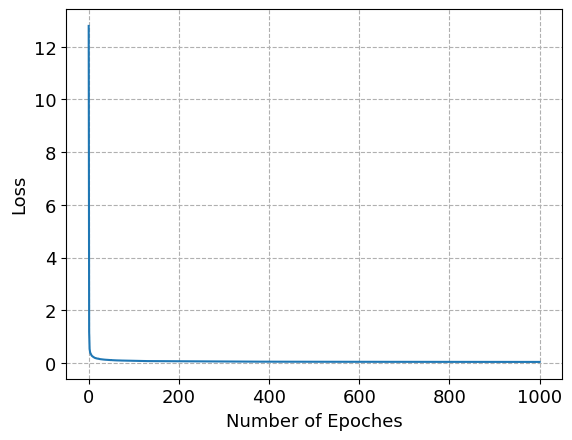

In [16]:
C = 5
N = 500
means = [[2, 2], [8, 3], [3, 6], [14, 2], [12, 8]]
cov = [[1, 0], [0, 1]]
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
X3 = np.random.multivariate_normal(means[3], cov, N)
X4 = np.random.multivariate_normal(means[4], cov, N)

X = np.concatenate((X0, X1, X2, X3, X4), axis = 0)
Xbar = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1) # bias trick
y = np.array([0]*N + [1]*N + [2]*N + [3]*N + [4]*N)

W_init = np.random.randn(Xbar.shape[1], C)
model = SoftmaxRegression()
w, loss_val = model.fit(Xbar, y, W_init, batch_size = 300)


plt.plot(loss_val)
plt.xlabel('Number of Epoches', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(linestyle = "--")
plt.show()

Data-Visualization

In [17]:
xm = np.arange(-2, 18, 0.025)
ym = np.arange(-3, 11, 0.025)
xx, yy = np.meshgrid(xm, ym)

xx1 = xx.ravel().reshape(-1, 1)  # x.ravel(): convert x to 1d-array
yy1 = yy.ravel().reshape(-1, 1)
XX = np.concatenate(( xx1, yy1, np.ones(( xx.size, 1))), axis = 1)
print(XX.shape)

pred = model.predict(XX)

(448000, 3)


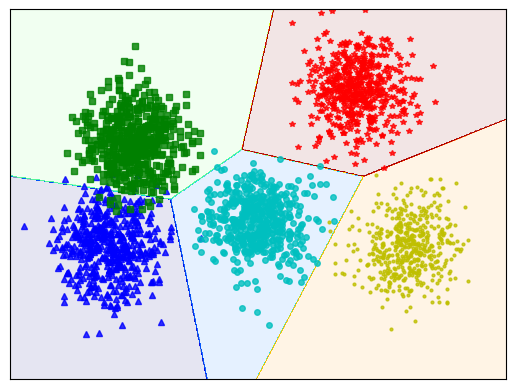

In [18]:
# Drawing data-point
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = 0.8)
plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = 0.8)
plt.plot(X2[:, 0], X2[:, 1], 'gs', markersize = 4, alpha = 0.8)
plt.plot(X3[:, 0], X3[:, 1], 'y.', markersize = 4, alpha = 0.8)
plt.plot(X4[:, 0], X4[:, 1], 'r*', markersize = 4, alpha = 0.8)
    
# Drawing backgound and boundary
pred = pred.reshape(xx.shape)
plt.contourf(xx, yy, pred, 200, cmap='jet', alpha = 0.1)
plt.xlim(-2, 18)
plt.ylim(-3, 11)
plt.xticks(())
plt.yticks(())
plt.show()

### MNIST

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

Load Data

In [20]:
(X_train_all, y_train_all), (X_test_all, y_test_all) = mnist.load_data() 

In [21]:
print(f"Shape of Train Set: {X_train_all.shape}")
print(f"Shape of Test Set: {X_test_all.shape}")

Shape of Train Set: (60000, 28, 28)
Shape of Test Set: (10000, 28, 28)


Data Preprocessing

In [22]:
X_train_all = X_train_all.reshape(X_train_all.shape[0], X_train_all.shape[1]*X_train_all.shape[2])
X_test_all = X_test_all.reshape(X_test_all.shape[0], X_test_all.shape[1]*X_test_all.shape[2])

# Data Scaling
X_train_scaled = X_train_all/255.0
X_test_scaled = X_test_all/255.0

X_train = np.concatenate((X_train_scaled, np.ones((X_train_scaled.shape[0], 1))), axis = 1)
y_train = y_train_all.copy()
X_test = np.concatenate((X_test_scaled, np.ones((X_test_scaled.shape[0], 1))), axis = 1)
y_test = y_test_all.copy()

print(X_train.shape)
print(X_test.shape)

(60000, 785)
(10000, 785)


Load model

Epochs progress: 100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]


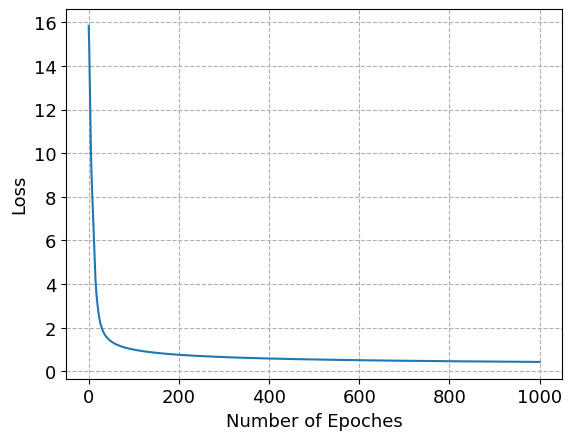

In [23]:
model = SoftmaxRegression()
coef_init = np.random.randn(X_train.shape[1], 10)
coef, loss = model.fit(X_train, y_train, coef_init)

plt.plot(loss)
plt.xlabel('Number of Epoches', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(linestyle = "--")
plt.show()

In [24]:
print(f"Loss Value: {loss[-1]}")

Loss Value: 0.4356324017589091


In [25]:
def accuracy_score(y_test : np.ndarray, y_pred : np.ndarray) -> float:
    return np.mean(y_test.ravel() == y_pred.ravel())

y_pred = model.predict(X_test)
print(f"Accuracy score : {accuracy_score(y_test, y_pred) * 100} %")

Accuracy score : 89.14999999999999 %


### Sklearn

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [27]:
model = LogisticRegression(C = 1e10,
                           solver = "lbfgs",
                           multi_class = "multinomial",
                           max_iter = 1000)
model.fit(X_train_scaled, y_train)

y_pred_by_sklearn = model.predict(X_test_scaled)
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred_by_sklearn) * 100} %")

Accuracy score : 92.24 %


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
